In [ ]:
#  %pip install patchify


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler


Segmentation Models: using `keras` framework.


In [3]:
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing



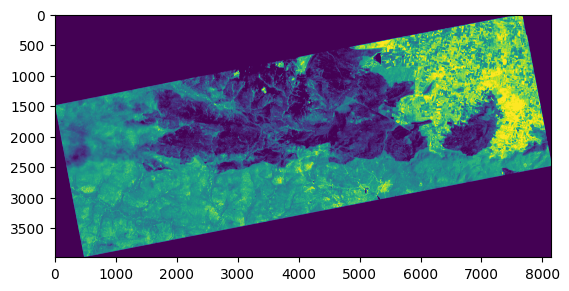

In [4]:
from keras.utils import to_categorical
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

img = cv2.imread("data/images/812.tif")
plt.imshow(img[:,:,2])
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
image = preprocess_input(input_img)

# original_mask = cv2.imread("data/masks/812_mask.tif")
# original_mask = original_mask[:,:,0]  #Use only single channel...

# # # original_mask = to_categorical(original_mask, num_classes=2)

In [7]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image, distances=[1], angles=[0]):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return contrast, homogeneity, energy, correlation

texture_features = extract_glcm_features(img)
print(texture_features)

(25.30602334040392, 0.5483885617086154, 0.39905278909116254, 0.9966790553526943)


In [5]:
# import numpy as np

# # Assuming input_img is a NumPy array
# input_img = input_img.astype(np.float32)

# # Now, input_img has been converted to float32 data type.
image.shape

(3979, 8139, 3)

In [6]:
from keras.models import load_model
model = load_model("UnetppLSTMDropout_Categorical_CrossEntropy_JaccardLoss_1e4AdamSoftmax50_resnet34_NewAug.hdf5", compile=False)

In [7]:
# #UnetDropout_TotalLoss_SoftmaxAdam250LRscheduleDecay1e4
# Unetcustom_TotalLoss_SoftmaxAdam250LRschedule2000Decay1e4
# # UnetDropout_CE_SoftmaxAdam250LRscheduleDecay3e4

#best model:UnetppLSTMDropout_Categorical_CrossEntropy_Loss_1e4AdamSoftmax50_resnet34_NewAug


from keras.models import load_model
model = load_model("Unetpp_CE500.hdf5", compile=False)

In [8]:
seed=24
batch_size= 16
n_classes=2
patch_size=256

In [9]:
# predictions_smooth = predict_img_with_smooth_windowing(
#     image,
#     window_size=patch_size,
#     subdivisions=2,  
#     nb_classes=2,
#     pred_func=(
#         lambda img_batch_subdiv: model.predict((img_batch_subdiv), batch_size=1)
#     )
# )

In [10]:
def preprocess_patch(patch, preprocess_input):
    """
    Apply preprocessing to a single patch.
    """
    patch = patch / 255.0 
    patch = preprocess_input(patch)
    return patch
def predict_img_with_smooth_windowing(image, window_size, subdivisions, nb_classes, pred_func, preprocess_input):
    """
    Predict segmentation for large images using a sliding window approach with smoothing.
    """
    image_height, image_width = image.shape[:2]
    
    full_predictions = np.zeros((image_height, image_width, nb_classes))
    count_predictions = np.zeros((image_height, image_width, nb_classes))
    
    step_size = window_size // subdivisions
    
    # Gaussian window to smooth predictions at edges
    gaussian_window = cv2.getGaussianKernel(window_size, window_size // 8)
    gaussian_window = gaussian_window * gaussian_window.T
    gaussian_window /= np.max(gaussian_window)
    
    for i in range(0, image_height, step_size):
        for j in range(0, image_width, step_size):
            # Calculate patch coordinates, making sure they don't exceed image boundaries
            start_i = i
            start_j = j
            end_i = min(start_i + window_size, image_height)
            end_j = min(start_j + window_size, image_width)
            
            # Extract the patch and preprocess it
            patch = np.zeros((window_size, window_size, image.shape[2]))
            patch[:end_i-start_i, :end_j-start_j, :] = image[start_i:end_i, start_j:end_j, :]
            patch = preprocess_patch(patch, preprocess_input)
            
            # Predict for the patch
            prediction = pred_func(np.expand_dims(patch, axis=0)).squeeze()
            
            # If the prediction size does not match, resize it
            if prediction.shape[:2] != (window_size, window_size):
                prediction = cv2.resize(prediction, (window_size, window_size), interpolation=cv2.INTER_LINEAR)
            
            # Compute the valid region in the prediction and add it to the full predictions
            valid_region_i = end_i - start_i
            valid_region_j = end_j - start_j
            
            full_predictions[start_i:end_i, start_j:end_j, :] += prediction[:valid_region_i, :valid_region_j, :] * gaussian_window[:valid_region_i, :valid_region_j, np.newaxis]
            count_predictions[start_i:end_i, start_j:end_j, :] += gaussian_window[:valid_region_i, :valid_region_j, np.newaxis]
    
    # Normalize the predictions
    full_predictions /= np.maximum(count_predictions, 1)  # Avoid division by zero
    
    return full_predictions

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Load image
image = cv2.imread("data/images/812.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define parameters
patch_size = 256
nb_classes = 2

# Define the prediction function
def predict_func(img_batch_subdiv):
    return model.predict(img_batch_subdiv, batch_size=1)

# Perform prediction
predictions_smooth = predict_img_with_smooth_windowing(
    image,
    window_size=patch_size,
    subdivisions=2,
    nb_classes=nb_classes,
    pred_func=predict_func,
    preprocess_input=preprocess_input
)




1/1 [==============================] - 0s 17ms/step


In [11]:
final_prediction = np.argmax(predictions_smooth, axis=2)
# test= np.squeeze(predictions_smooth)
final_prediction.shape

(3979, 8139)

(-0.5, 8138.5, 3978.5, -0.5)

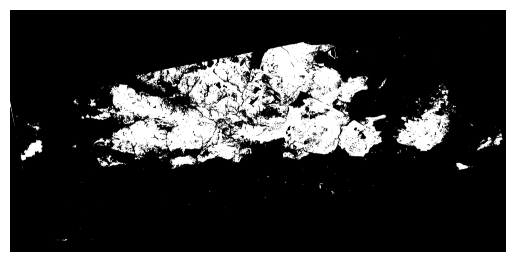

In [13]:
plt.imshow(final_prediction, cmap='gray')
plt.axis('off')
# plt.savefig('data/res/_seg.jpg', bbox_inches='tight', pad_inches=0) 


In [14]:
import matplotlib.pyplot as plt
import imageio
imageio.imsave('data/res/UnetppLSTMDropout_Categorical_CrossEntropy_JaccardLoss_1e4AdamSoftmax50_resnet34_NewAug_812_Seg.tif', final_prediction)
temp_img = cv2.imread("data/images/812.tif", cv2.IMREAD_UNCHANGED)
imageio.imsave('data/res/812.tif', temp_img[:, :, [2,1,0]]) 


C:\Users\sbalakavi\AppData\Local\Temp\ipykernel_11492\2409727882.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_image = imageio.imread(pred_image_path)


Confusion Matrix:
[[27106511   194176]
 [  166028  4918366]]
Precision: 0.9620196763175736
Recall: 0.9673455676330355
F1 Score: 0.9646752710814307
Accuracy: 0.9888774710799705


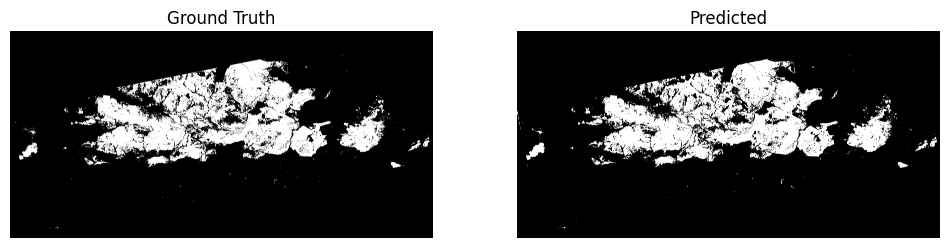

In [15]:
import cv2
import imageio
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
gt_image_path = 'data/masks/812_mask.tif'
pred_image_path = 'data/res/UnetppLSTMDropout_Categorical_CrossEntropy_JaccardLoss_1e4AdamSoftmax50_resnet34_NewAug_812_Seg.tif'

gt_image = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)
pred_image = imageio.imread(pred_image_path)

# Convert ground truth image to binary
gt_image_binary = (gt_image > 0).astype(int)  

# Ensure predicted image is binary
if len(pred_image.shape) == 3 and pred_image.shape[2] > 1:
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_RGB2GRAY)
pred_image_binary = (pred_image > 0).astype(int)  

# Function to calculate metrics for binary classification
def calculate_metrics(gt_img, pred_img):
    # Flatten the images to 1D arrays
    gt_flat = gt_img.flatten()
    pred_flat = pred_img.flatten()
    
    # Calculate confusion matrix
    cm = confusion_matrix(gt_flat, pred_flat)
    
    # Calculate Precision, Recall, F1 Score, and Accuracy
    precision = precision_score(gt_flat, pred_flat, average='binary', zero_division=0)
    recall = recall_score(gt_flat, pred_flat, average='binary', zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, average='binary', zero_division=0)
    accuracy = accuracy_score(gt_flat, pred_flat)
    
    return cm, precision, recall, f1, accuracy

# Calculate metrics
conf_matrix, precision, recall, f1, accuracy = calculate_metrics(gt_image_binary, pred_image_binary)

# Print overall metrics
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Plotting the images for visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(gt_image_binary, cmap='gray')
axes[0].set_title('Ground Truth')
axes[0].axis('off')

axes[1].imshow(pred_image_binary, cmap='gray')
axes[1].set_title('Predicted')
axes[1].axis('off')

plt.show()


In [11]:
print("Unique values in GT image:", np.unique(gt_image))
print("Unique values in Prediction image:", np.unique(pred_image))

Unique values in GT image: [  0 255]
Unique values in Prediction image: [0 1]


### Refining result

In [4]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image, distances=[1], angles=[0]):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return contrast, homogeneity, energy, correlation

texture_features = extract_glcm_features(img)
print(texture_features)

(25.30602334040392, 0.5483885617086154, 0.39905278909116254, 0.9966790553526943)


In [16]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops

# Function to extract GLCM features from an image patch
def extract_glcm_features(patch):
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_patch, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

# Load segmented image
segmented_image = cv2.imread('UnetppLSTMDropout_Categorical_CrossEntropy_Loss_1e4AdamSoftmax50_resnet34_NewAug_812_Seg.tif', cv2.IMREAD_UNCHANGED)

if segmented_image is None:
    raise ValueError("Failed to load segmented image")

height, width = segmented_image.shape[:2]

# Define patch size (e.g., 64x64 or 128x128)
patch_size = 64

feature_vectors = []
labels = []

for i in range(0, height - patch_size + 1, patch_size):
    for j in range(0, width - patch_size + 1, patch_size):
        # Extract patch
        patch = segmented_image[i:i+patch_size, j:j+patch_size]
        label = np.mean(segmented_image[i:i+patch_size, j:j+patch_size])  # Example label extraction

        # Extract texture features
        texture_vector = extract_glcm_features(patch)
        feature_vector = [label] + texture_vector
        feature_vectors.append(feature_vector)

# Convert to numpy array for further processing
feature_vectors = np.array(feature_vectors)


In [17]:
feature_vectors

array([[64.21691895, 64.50892857,  0.99900795,  0.9975212 ,  0.74950298],
       [63.75      ,  0.        ,  1.        ,  1.        ,  1.        ],
       [63.75      ,  0.        ,  1.        ,  1.        ,  1.        ],
       ...,
       [63.75      ,  0.        ,  1.        ,  1.        ,  1.        ],
       [63.75      ,  0.        ,  1.        ,  1.        ,  1.        ],
       [63.75      ,  0.        ,  1.        ,  1.        ,  1.        ]])

In [21]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to extract GLCM features from an image patch
def extract_glcm_features(patch):
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_patch, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

# Load segmented image
segmented_image = cv2.imread('UnetppLSTMDropout_Categorical_CrossEntropy_Loss_1e4AdamSoftmax50_resnet34_NewAug_812_Seg.tif', cv2.IMREAD_UNCHANGED)

if segmented_image is None:
    raise ValueError("Failed to load segmented image")

height, width = segmented_image.shape[:2]

# Define patch size
patch_size = 64

feature_vectors = []
labels = []

# Load ground truth mask
ground_truth = cv2.imread('data/masks/812_mask.tif', cv2.IMREAD_UNCHANGED)
if ground_truth is None:
    raise ValueError("Failed to load ground truth mask")

# Extract features from image patches
for i in range(0, height - patch_size + 1, patch_size):
    for j in range(0, width - patch_size + 1, patch_size):
        # Extract patch
        patch = segmented_image[i:i+patch_size, j:j+patch_size]
        patch_ground_truth = ground_truth[i:i+patch_size, j:j+patch_size]

        if patch.size == 0:
            continue  # Skip empty patches
        
        # Extract texture features
        texture_vector = extract_glcm_features(patch)

        # Determine the label for the patch
        unique_labels = np.unique(patch_ground_truth)
        if unique_labels.size > 0:
            label = unique_labels[0]  # Use the first label found

            # Append feature vector and label
            feature_vectors.append(texture_vector)
            labels.append(label)

# Convert to numpy arrays
feature_vectors = np.array(feature_vectors)
labels = np.array(labels)

if len(feature_vectors) == 0 or len(labels) == 0:
    raise ValueError("Feature vectors or labels are empty")

# Check if the lengths of feature_vectors and labels are consistent
if len(feature_vectors) != len(labels):
    raise ValueError("Mismatch between number of feature vectors and labels")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Classifier Accuracy:", accuracy)


Classifier Accuracy: 0.9936507936507937


In [27]:
    refined_labels = classifier.predict(feature_vectors)
    
    # refined_image = refined_labels.reshape(segmented_image.shape)  # Reshape to the original image size


In [35]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer

def extract_glcm_features(image, distances=[1], angles=[0]):
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

# Load images
original_image = cv2.imread('data/images/812.tif', cv2.IMREAD_COLOR)  # Load original image
segmented_image = cv2.imread('UnetppLSTMDropout_Categorical_CrossEntropy_Loss_1e4AdamSoftmax50_resnet34_NewAug_812_Seg.tif', cv2.IMREAD_GRAYSCALE)

if original_image is None or segmented_image is None:
    raise ValueError("Failed to load images")

height, width = segmented_image.shape
patch_size = 64

feature_vectors = []
labels = []

# Extract features from image patches
for i in range(0, height - patch_size + 1, patch_size):
    for j in range(0, width - patch_size + 1, patch_size):
        patch_original = original_image[i:i+patch_size, j:j+patch_size]
        patch_segmented = segmented_image[i:i+patch_size, j:j+patch_size]

        if patch_original.size == 0 or patch_segmented.size == 0:
            continue  # Skip empty patches
        
        # Extract texture features from the segmented image
        texture_vector = extract_glcm_features(patch_segmented)

        # Flatten the original image patch for feature extraction
        original_features = patch_original.flatten()

        # Combine original and texture features
        feature_vector = np.concatenate([original_features, texture_vector])
        
        # Use the pixel value from the segmented image as the label
        label = np.mean(patch_segmented)  # Averaging pixel values as a simplistic label
        
        # Append feature vector and label
        feature_vectors.append(feature_vector)
        labels.append(label)

# Convert to numpy arrays
feature_vectors = np.array(feature_vectors)
labels = np.array(labels)

if len(feature_vectors) == 0 or len(labels) == 0:
    raise ValueError("Feature vectors or labels are empty")

# Discretize the labels into bins for classification
# Here we use 10 bins, adjust based on your data
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
labels = discretizer.fit_transform(labels.reshape(-1, 1)).flatten()

# Check if the lengths of feature_vectors and labels are consistent
if len(feature_vectors) != len(labels):
    raise ValueError("Mismatch between number of feature vectors and labels")

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components as needed
feature_vectors = pca.fit_transform(feature_vectors)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict refined labels
refined_labels = classifier.predict(feature_vectors)

# Initialize an empty array for the reconstructed image
reconstructed_image = np.zeros((height, width), dtype=np.uint8)

# Reconstruct the full image from patches
patch_count = 0
for i in range(0, height - patch_size + 1, patch_size):
    for j in range(0, width - patch_size + 1, patch_size):
        # Ensure the patch count does not exceed the length of refined_labels
        if patch_count >= len(refined_labels):
            break
        
        # Get the label for the current patch
        label = refined_labels[patch_count]
        # Place the patch label into the reconstructed image
        reconstructed_image[i:i+patch_size, j:j+patch_size] = label
        patch_count += 1

# Save the reconstructed image
cv2.imwrite('data/res/reconstructed_image.tif', reconstructed_image)
print("Reconstructed image saved as 'reconstructed_image.tif'")


Reconstructed image saved as 'reconstructed_image.tif'
